In [1]:
# import dependencies
import spektral
import tensorflow as tf
from spektral.layers import GraphConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
import numpy as np

### 1. Perform GCN on the Cora dataset ###

In [2]:
## load cora data set
cora_A, cora_X, cora_L, cora_train_mask, cora_val_mask, cora_test_mask = spektral.datasets.citation.load_data(dataset_name='cora',
                                                                                                              normalize_features=False, 
                                                                                                              random_split=False)

Loading cora dataset


cora_A - adjacency matrix

cora_X - feature matrix (doc by term)

cora_L - label

In [3]:
# define number of nodes, features and classes
num_cora_nodes = cora_A.shape[0]
num_cora_features = cora_X.shape[1]
num_cora_classes = cora_L.shape[1]

In [4]:
# print out attributes
print('shape of cora Adjacency Matrix: {} x {}'.format(num_cora_nodes, num_cora_nodes))
print('number of cora features (number of termrs): ', num_cora_features)
print('number of cora classes: ', num_cora_classes)

shape of cora Adjacency Matrix: 2708 x 2708
number of cora features (number of termrs):  1433
number of cora classes:  7


In [5]:
print('training data size: ', cora_train_mask.sum())
print('validation data size: ', cora_val_mask.sum())
print('test data size: ', cora_test_mask.sum())

training data size:  140
validation data size:  500
test data size:  1000


In [6]:
# check the distribution of each class for balance
cora_L.sum(axis = 0)

array([351, 217, 418, 818, 426, 298, 180])

### 1.1 plot Cora using Truth labels

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# convert label from hot-encoding back to single value encoding
cora_y = [list(label).index(1) + 1 for label in cora_L]
cora_y = np.asarray(cora_y)
# make a pandas series copy of cora_y
series_cora_y = pd.Series(cora_y)

In [9]:
# create a color mapping for labels
# colors are chosen arbitrarily 
label_color_mapping = {1:'red',
                       2:'sienna',
                       3:'orange',
                       4:'yellowgreen',
                       5:'turquoise',
                       6:'royalblue',
                       7:'violet'}
# map colors to labels
series_cora_y.replace(label_color_mapping,
                      inplace = True)
# convert back to numpy array
color_cora_y = series_cora_y.to_numpy()

In [10]:
# convert adjacency matrix to a graph
graph = nx.from_numpy_matrix(cora_A.toarray())

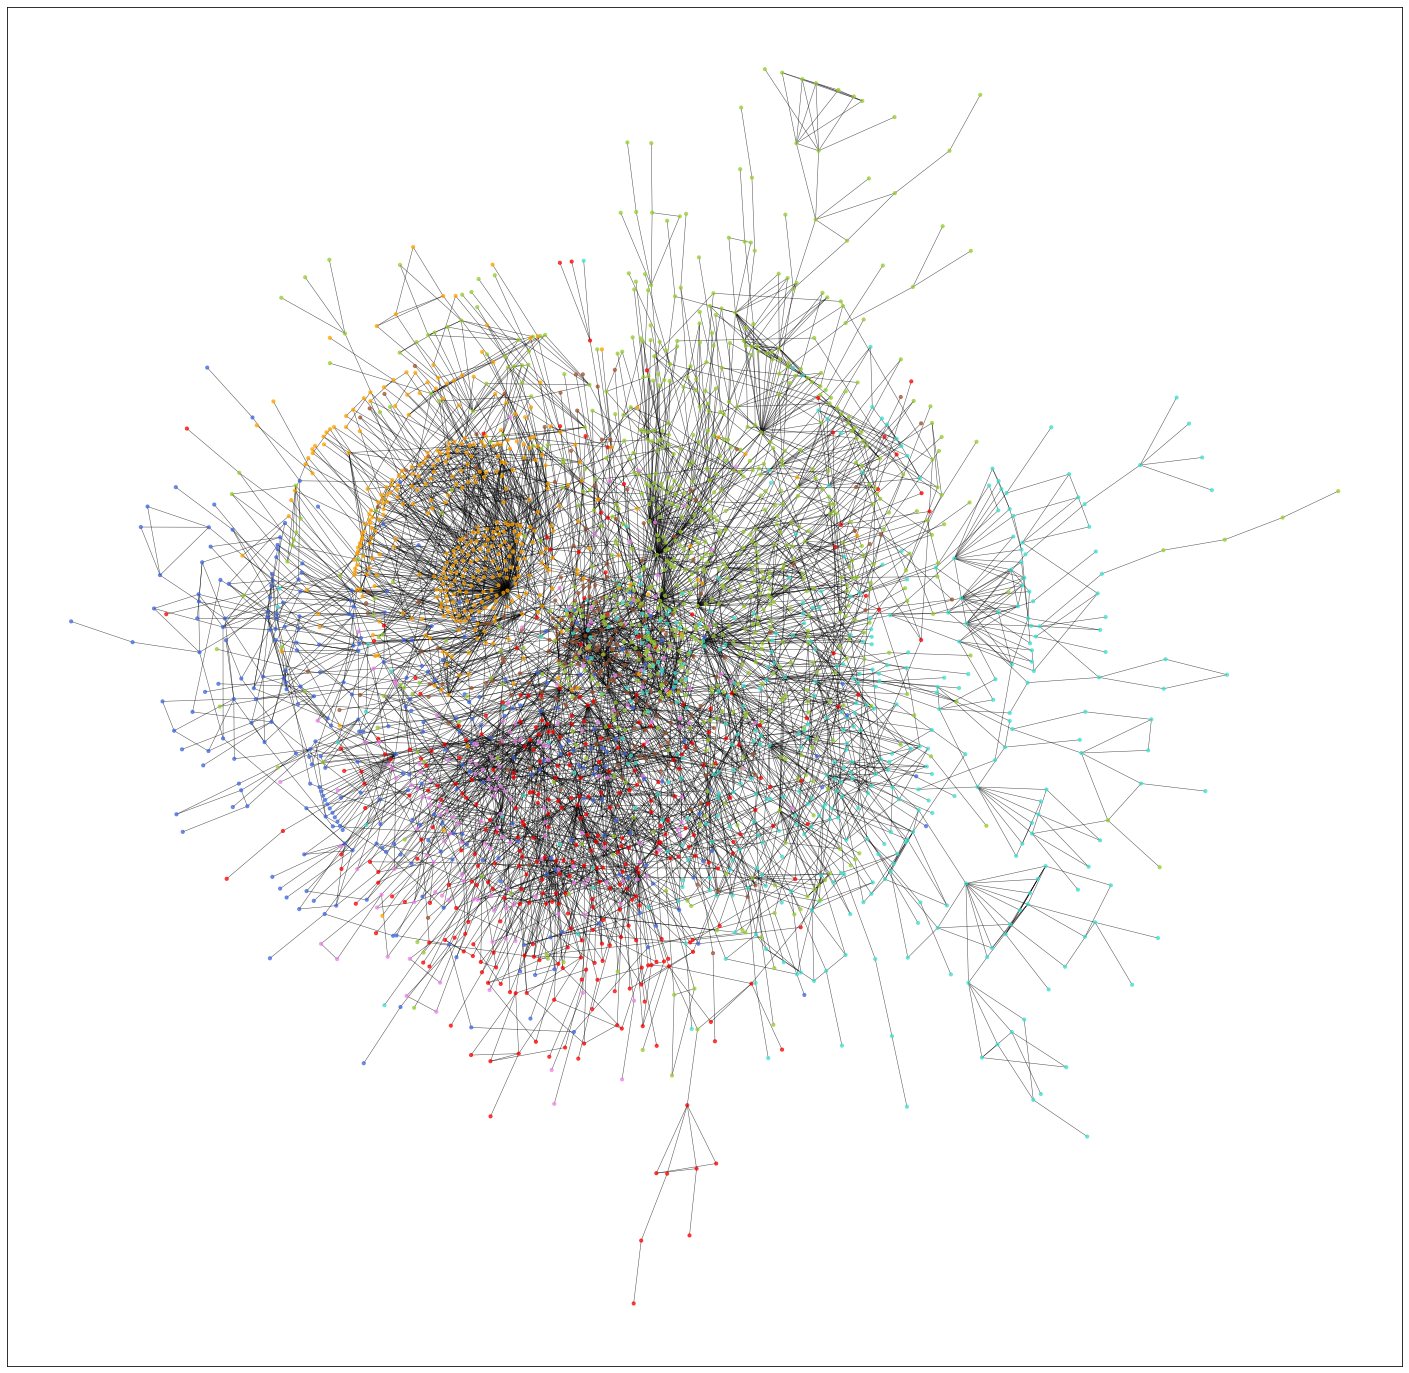

In [11]:
plt.figure(figsize=(25, 25))
# kamada-kawai path-length layout
node_pos = nx.kamada_kawai_layout(graph, scale = 1.5)
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_y,
               alpha = 0.7,
               width = 0.5)
plt.show()

### 1.2 Construct a GCN and Make Predictions

In [12]:
# define feature and adjacency input to the first GCN layer
cora_X_in = Input(shape = (num_cora_features, ))
cora_A_in = Input(shape = (num_cora_nodes, ), sparse = True)
# construct 3 layers of GCN, features beuing reduced to
# 64, 32 and 7 (number of classes)
# use drop out of 0.5 to minimize overfitting
cora_X_1 = GraphConv(64, 'relu')([cora_X_in, cora_A_in])
cora_X_1 = Dropout(0.5)(cora_X_1)
cora_X_2 = GraphConv(32, 'relu')([cora_X_1, cora_A_in])
cora_X_2 = Dropout(0.5)(cora_X_2)
cora_X_3 = GraphConv(num_cora_classes, 'softmax')([cora_X_2, cora_A_in])
# use keras functional API to construct a GCN model
cora_model = Model(inputs = [cora_X_in, cora_A_in], outputs = cora_X_3, name = 'cora_GCN_model')

In [13]:
# preprocess adjacency matrix to add self-loops and scale edge weights
cora_A = GraphConv.preprocess(cora_A).astype('f4')

In [14]:
# compile model
cora_model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             weighted_metrics = ['acc', tf.keras.metrics.AUC()])
cora_model.summary()

Model: "cora_GCN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 64)           91776       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           graph_conv[0][0]    

In [15]:
# define number of epochs
cora_epochs = 50
# Prepare data
cora_X = cora_X.toarray()

In [16]:
# prepare val data
cora_val_data = ([cora_X, cora_A], cora_L, cora_val_mask)
# Train model
cora_model.fit([cora_X, cora_A], cora_L,
               sample_weight = cora_train_mask,
               validation_data = cora_val_data,
               epochs = cora_epochs,
               batch_size = num_cora_nodes,
               shuffle = False)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 0.1002 - acc: 0.2071 - auc: 0.5377 - val_loss: 0.3590 - val_acc: 0.1720 - val_auc: 0.4993
Epoch 2/50
1/1 [==============================] - 0s 429ms/step - loss: 0.1003 - acc: 0.1643 - auc: 0.5395 - val_loss: 0.3576 - val_acc: 0.1960 - val_auc: 0.5413
Epoch 3/50
1/1 [==============================] - 0s 425ms/step - loss: 0.0985 - acc: 0.2714 - auc: 0.6562 - val_loss: 0.3562 - val_acc: 0.2100 - val_auc: 0.5805
Epoch 4/50
1/1 [==============================] - 0s 417ms/step - loss: 0.0984 - acc: 0.3071 - auc: 0.6744 - val_loss: 0.3546 - val_acc: 0.2280 - val_auc: 0.6219
Epoch 5/50
1/1 [==============================] - 0s 421ms/step - loss: 0.0977 - acc: 0.3000 - auc: 0.7224 - val_loss: 0.3530 - val_acc: 0.2340 - val_auc: 0.6586
Epoch 6/50
1/1 [==============================] - 0s 417ms/step - loss: 0.0966 - acc: 0.4071 - auc: 0.7764 - val_loss: 0.3512 - val_acc: 0.2520 - val_auc: 0.6915
Epoch 7/50
1/1 [===============

In [17]:
# Evaluate model
eval_results = cora_model.evaluate([cora_X, cora_A], 
                                   cora_L,
                                   sample_weight = 1 - (cora_train_mask + cora_val_mask),
                                   batch_size = num_cora_nodes)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

1/1 [==============================] - 0s 2ms/step - loss: 0.7408 - acc: 0.7969 - auc: 0.9572
Done.
Test loss: 0.740821897983551
Test accuracy: 0.7969052195549011


In [18]:
# use GCN to make prediction
cora_predict = cora_model.predict([cora_X, cora_A],
                                 batch_size = num_cora_nodes)
cora_predict = np.argmax(cora_predict, axis = 1) + 1

In [19]:
# create a confusion matrix 
GCN_confmat = tf.math.confusion_matrix(cora_y-1, cora_predict-1, num_classes=7)

In [20]:
# import dependencies
import seaborn as sns

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


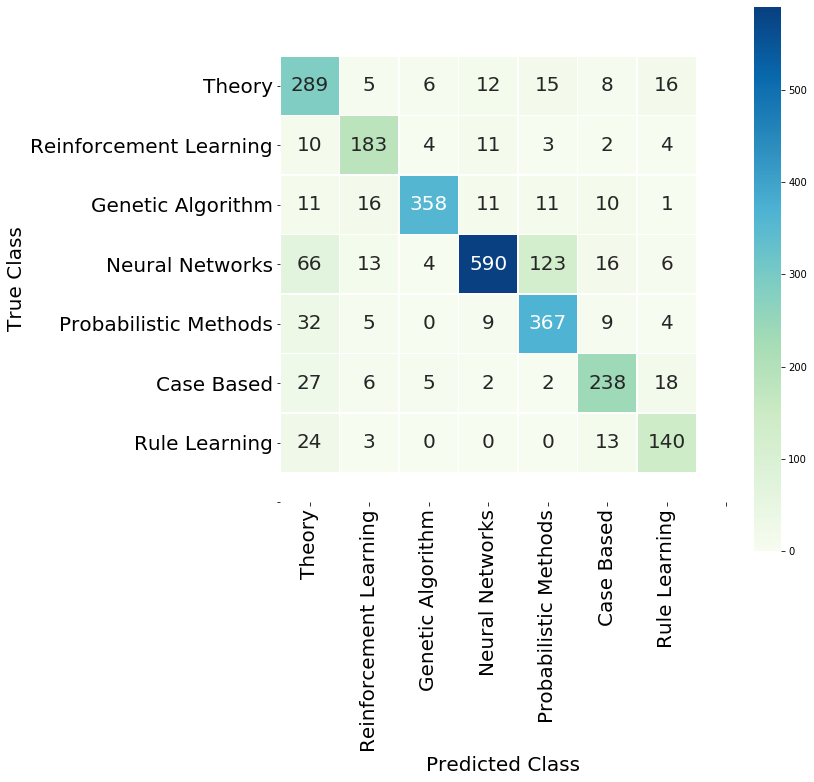

In [21]:
# define class labels:
class_labels = ['Theory', 'Reinforcement Learning', 'Genetic Algorithm', 'Neural Networks', 'Probabilistic Methods', 'Case Based', 'Rule Learning']
# use a heatmap to visualize confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(GCN_confmat.numpy(), 
            annot= True, 
            fmt = 'd',
            annot_kws = {'size': 20},
            linewidths = 0.5,
            cmap="GnBu",
            square = True)
# define ticks location and label
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 0)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 90)
# define font size
plt.ylabel('True Class', fontdict = {'size': 20})
plt.xlabel('Predicted Class', fontdict = {'size': 20})
plt.show()

In [22]:
from sklearn.metrics import f1_score

In [23]:
GCN_f1 = f1_score(cora_y, cora_predict, labels=[1, 2, 3, 4, 5, 6, 7], average = None)
for l, f in zip(class_labels, GCN_f1):
    print('F1 score for {}: {:.2f}'.format(l, f))

F1 score for Theory: 0.71
F1 score for Reinforcement Learning: 0.82
F1 score for Genetic Algorithm: 0.90
F1 score for Neural Networks: 0.81
F1 score for Probabilistic Methods: 0.78
F1 score for Case Based: 0.80
F1 score for Rule Learning: 0.76


### 1.3 Plot Predictions made by GCN

In [24]:
# color code the prediction
color_cora_predict = pd.Series(cora_predict)
color_cora_predict = color_cora_predict.replace(label_color_mapping).to_numpy()

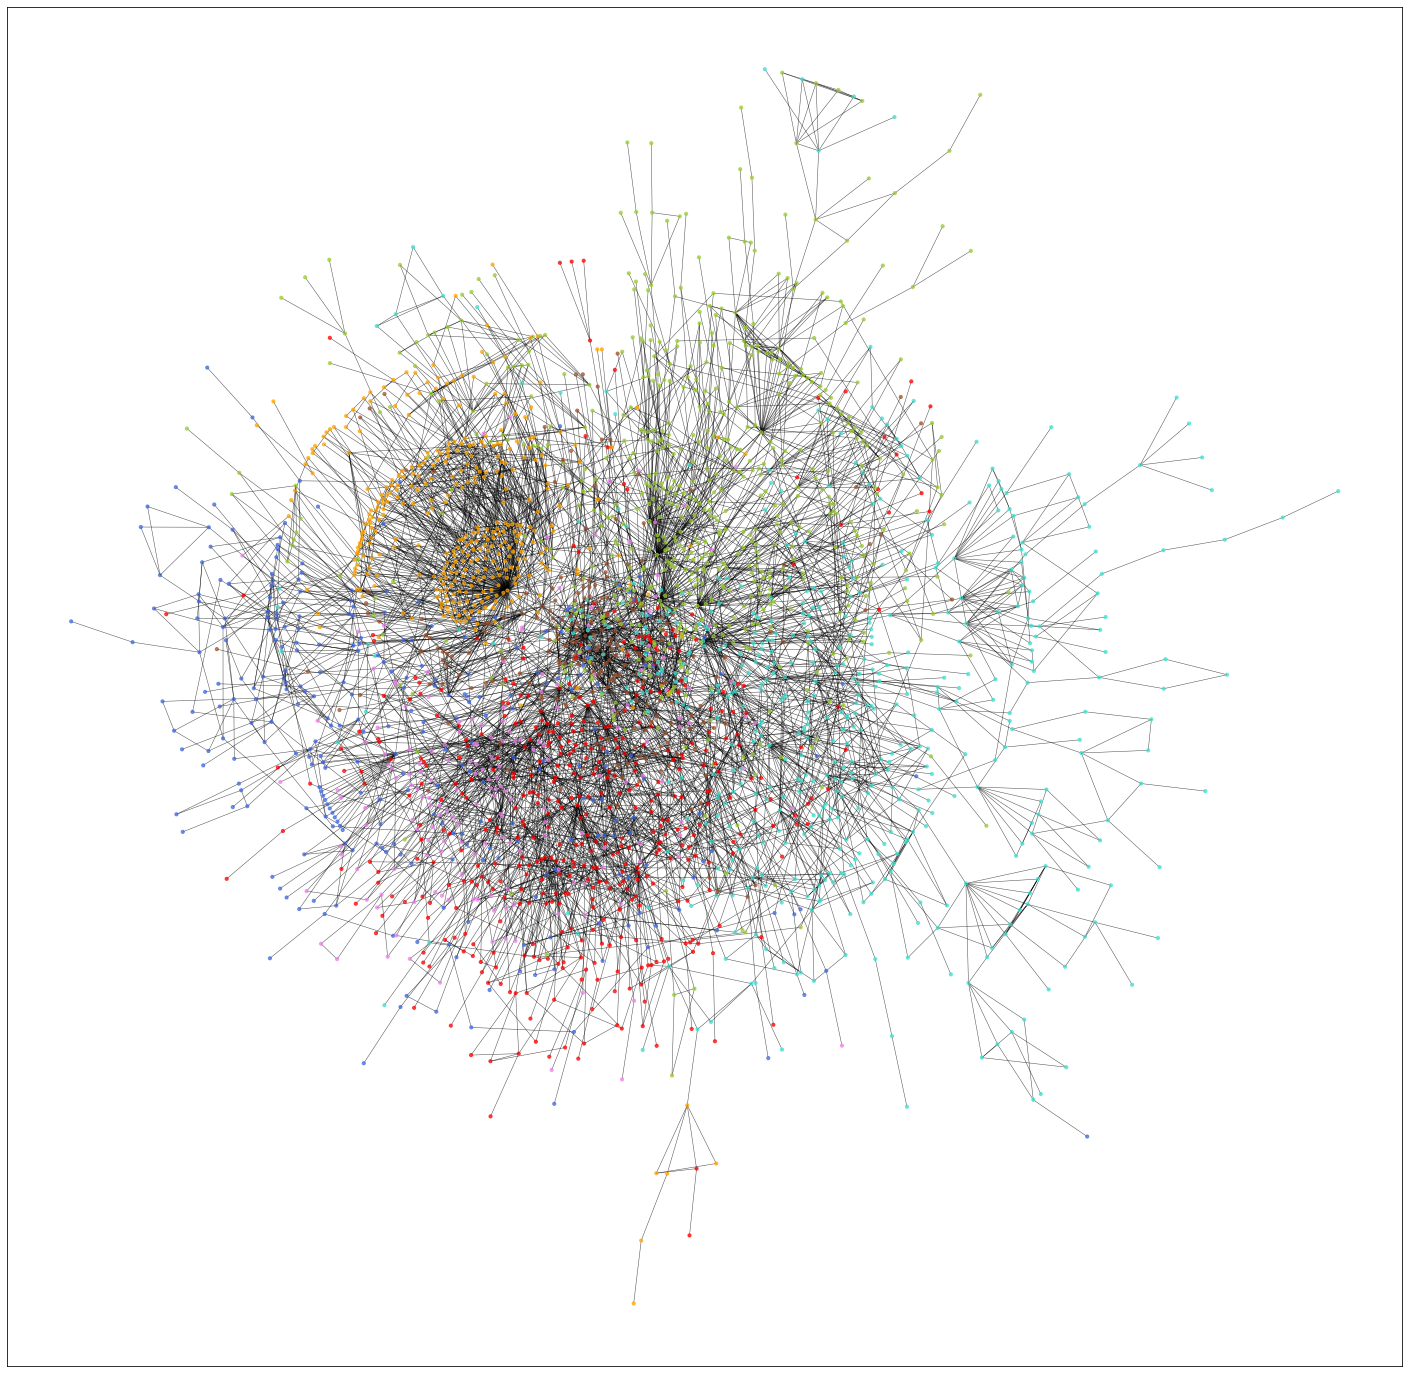

In [25]:
plt.figure(figsize=(25, 25))
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_predict,
               alpha = 0.7,
               width = 0.5)
plt.show()

### Visualize False Predictions

#### - Red: False label

In [26]:
# identify correct matches
cora_matched = (cora_y == cora_predict).astype('int32')

In [27]:
# define color mapping
matched_color_mapping = {1:'white',
                         0:'red'}

In [28]:
# color code matches
color_cora_matched = pd.Series(cora_matched)
color_cora_matched = color_cora_matched.replace(matched_color_mapping).to_numpy()

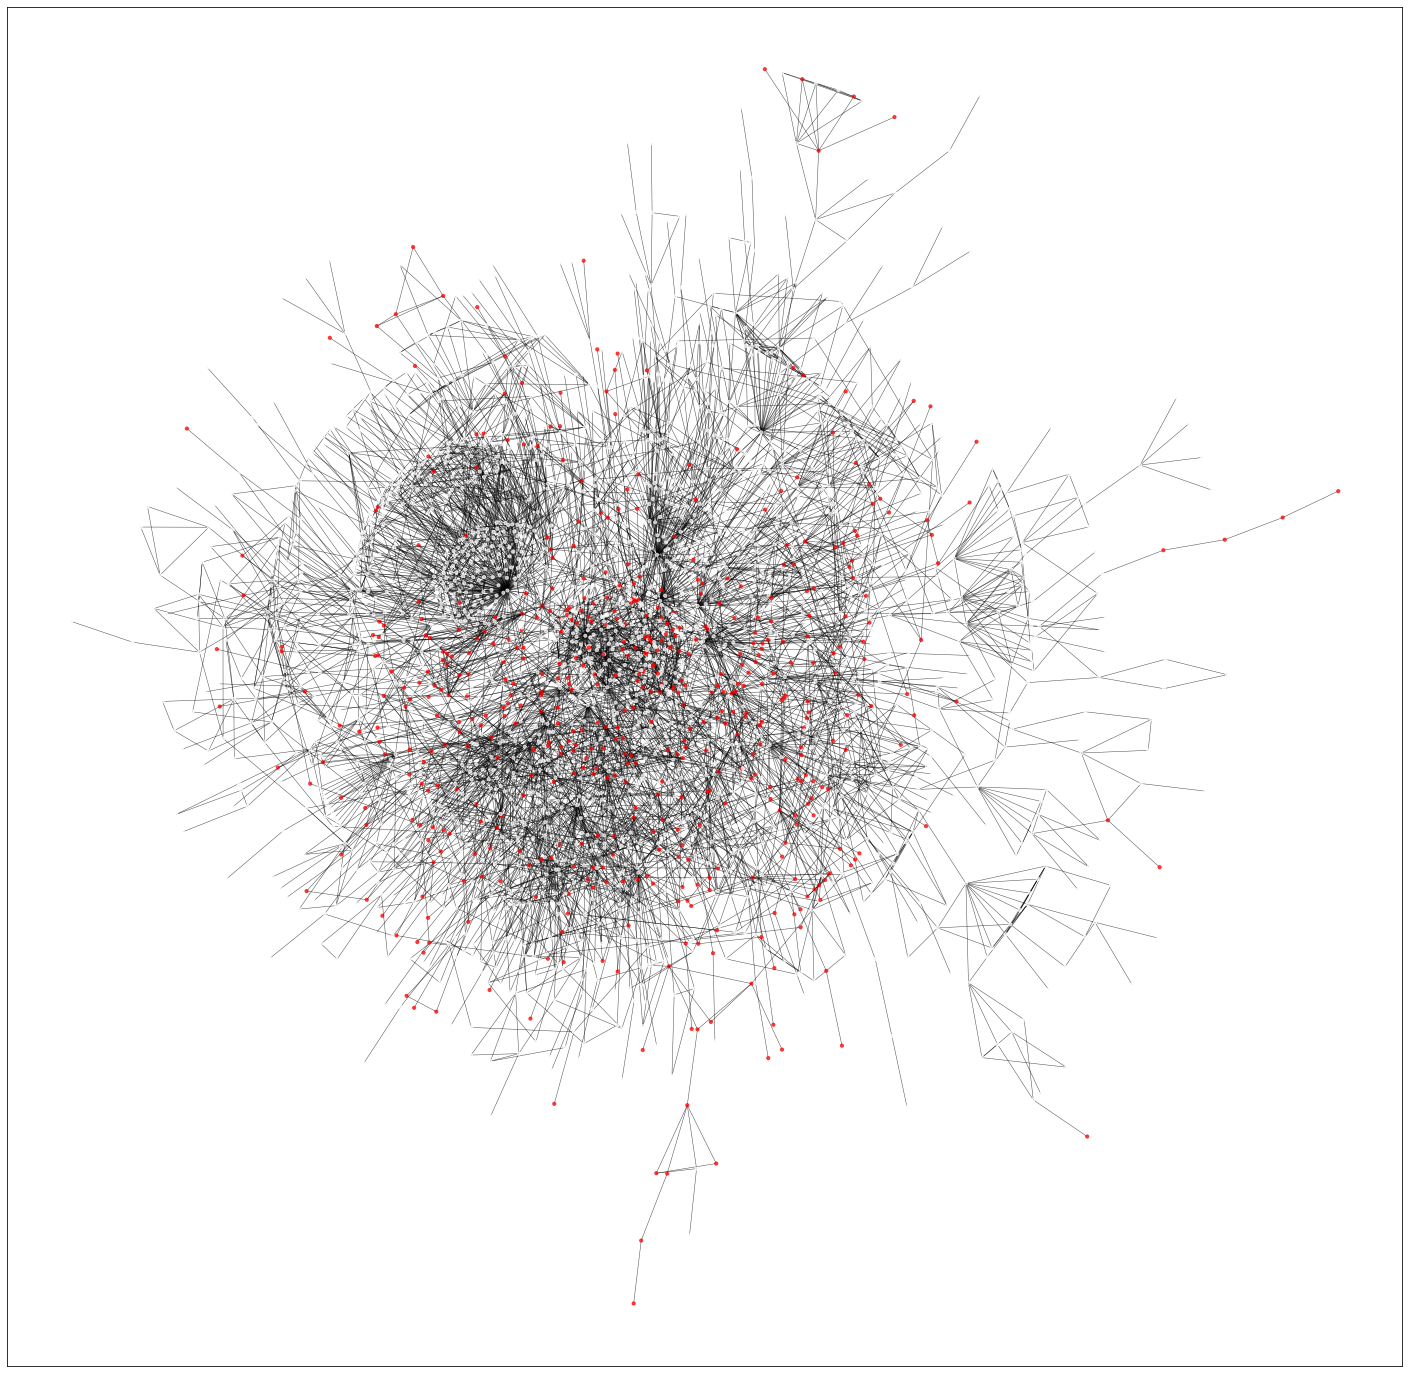

In [29]:
plt.figure(figsize=(25, 25))
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_matched,
               alpha = 0.7,
               width = 0.5)
plt.show()

### Use Naive Bayes Classifier on Cora dataset (Multinomial)

In [8]:
# import dependencies
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [9]:
# instantiate a Multinominal NB classifier class
nb_multinomial = MultinomialNB()

In [10]:
# convert label from hot-encoding back to single value encoding
cora_y = [list(label).index(1) + 1 for label in cora_L]
cora_y = np.asarray(cora_y)

In [11]:
# train_test split the original data
# using only 5% of the data for training (same as GCN)
cora_X_train, cora_X_test, cora_y_train, cora_y_test = train_test_split(cora_X, cora_y,
                                                                       test_size = 0.9483,
                                                                       random_state = 44)
print('train size: ', cora_X_train.shape[0])
print('test size: ', cora_X_test.shape[0])

train size:  140
test size:  2568


In [16]:
max(cora_X_train.toarray().sum(axis = 1))

26.0

In [34]:
# fit classiifer on training data
nb_multinomial.fit(cora_X_train, cora_y_train)
# make predition and evaluate on training data
print('mean accuracy on training set: ', nb_multinomial.score(cora_X_train, cora_y_train))

mean accuracy on training set:  0.9928571428571429


In [35]:
# make predition and evaluate on testing data
print('mean accuracy on testing set: ', nb_multinomial.score(cora_X_test, cora_y_test))

mean accuracy on testing set:  0.5774922118380063


In [36]:
cora_nb_predict = nb_multinomial.predict(cora_X)
# identify correct matches
cora_nb_matched = (cora_y == cora_nb_predict).astype('int32')
# color code matches
color_cora_nb_matched = pd.Series(cora_nb_matched)
color_cora_nb_matched = color_cora_nb_matched.replace(matched_color_mapping).to_numpy()

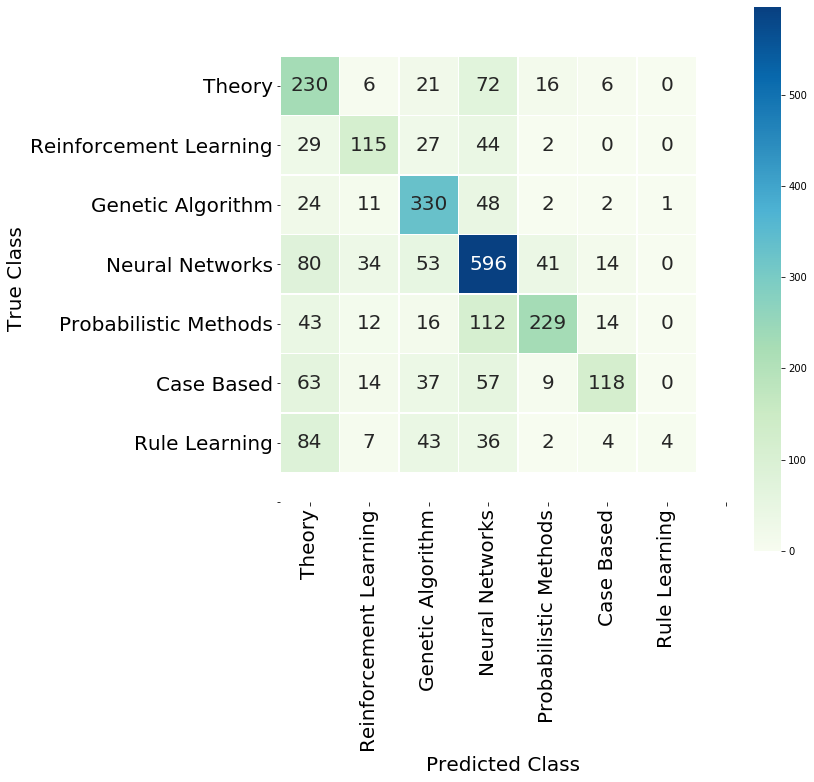

In [37]:
# create a confusion matrix 
nb_confmat = tf.math.confusion_matrix(cora_y-1, cora_nb_predict-1, num_classes=7)
# use a heatmap to visualize confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(nb_confmat.numpy(), 
            annot= True, 
            fmt = 'd',
            annot_kws = {'size': 20},
            linewidths = 0.5,
            cmap="GnBu",
            square = True)
# define ticks location and label
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 0)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 90)
# define font size
plt.ylabel('True Class', fontdict = {'size': 20})
plt.xlabel('Predicted Class', fontdict = {'size': 20})
plt.show()

In [38]:
nb_f1 = f1_score(cora_y, cora_nb_predict, labels=[1, 2, 3, 4, 5, 6, 7], average = None)
for l, f in zip(class_labels, nb_f1):
    print('F1 score for {}: {:.2f}'.format(l, f))

F1 score for Theory: 0.51
F1 score for Reinforcement Learning: 0.55
F1 score for Genetic Algorithm: 0.70
F1 score for Neural Networks: 0.67
F1 score for Probabilistic Methods: 0.63
F1 score for Case Based: 0.52
F1 score for Rule Learning: 0.04


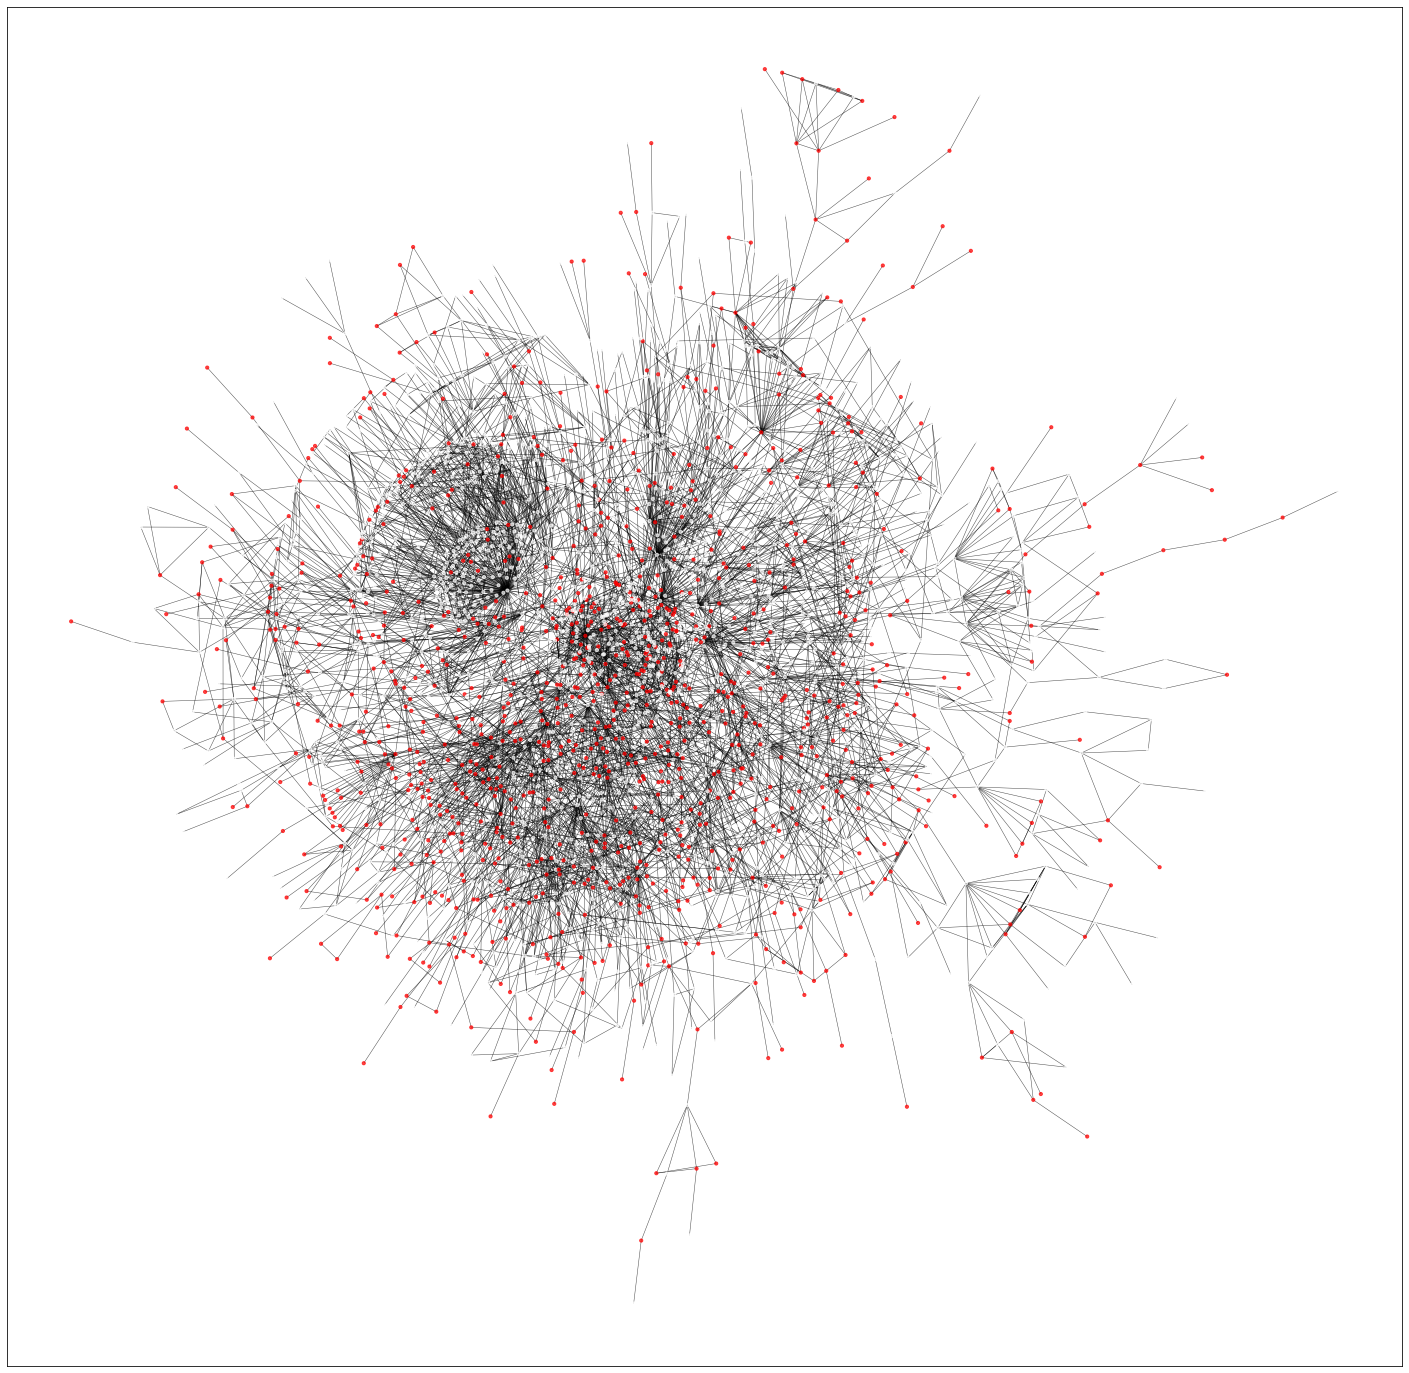

In [39]:
plt.figure(figsize=(25, 25))
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_nb_matched,
               alpha = 0.7,
               width = 0.5)
plt.show()

### Use Logistic Regression Classifier on Cora dataset

In [40]:
# import dependencies
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [41]:
# instantiate a logistic regressor class
LR_model = LogisticRegression(penalty = 'l2', 
                              solver = 'lbfgs')

In [42]:
LR_model.fit(cora_X_train, cora_y_train)
# make predition and evaluate on training data
print('mean accuracy on training set: ', LR_model.score(cora_X_train, cora_y_train))
LR_train_predict = LR_model.predict_proba(cora_X_train)
print('AUC on training set: ', roc_auc_score(cora_y_train, LR_train_predict, multi_class = 'ovr'))

mean accuracy on training set:  1.0
AUC on training set:  1.0


In [43]:
# make predition and evaluate on testing data
print('mean accuracy on testing set: ', LR_model.score(cora_X_test, cora_y_test))
LR_test_predict = LR_model.predict_proba(cora_X_test)
print('AUC on testing set: ', roc_auc_score(cora_y_test, LR_test_predict, multi_class = 'ovr'))

mean accuracy on testing set:  0.588006230529595
AUC on testing set:  0.8654011421404594


In [44]:
cora_LR_predict = LR_model.predict(cora_X)
# identify correct matches
cora_LR_matched = (cora_y == cora_LR_predict).astype('int32')
# color code matches
color_cora_LR_matched = pd.Series(cora_LR_matched)
color_cora_LR_matched = color_cora_LR_matched.replace(matched_color_mapping).to_numpy()

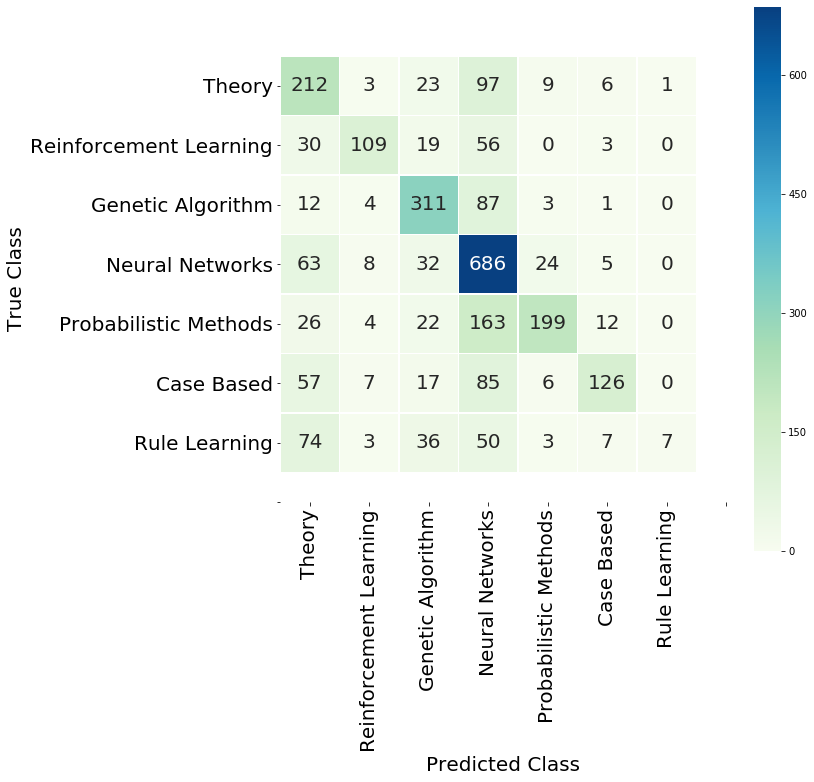

In [45]:
# create a confusion matrix 
LR_confmat = tf.math.confusion_matrix(cora_y-1, cora_LR_predict-1, num_classes=7)
# use a heatmap to visualize confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(LR_confmat.numpy(), 
            annot= True, 
            fmt = 'd',
            annot_kws = {'size': 20},
            linewidths = 0.5,
            cmap="GnBu",
            square = True)
# define ticks location and label
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 0)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 90)
# define font size
plt.ylabel('True Class', fontdict = {'size': 20})
plt.xlabel('Predicted Class', fontdict = {'size': 20})
plt.show()

In [46]:
LR_f1 = f1_score(cora_y, cora_LR_predict, labels=[1, 2, 3, 4, 5, 6, 7], average = None)
for l, f in zip(class_labels, LR_f1):
    print('F1 score for {}: {:.2f}'.format(l, f))

F1 score for Theory: 0.51
F1 score for Reinforcement Learning: 0.61
F1 score for Genetic Algorithm: 0.71
F1 score for Neural Networks: 0.67
F1 score for Probabilistic Methods: 0.59
F1 score for Case Based: 0.55
F1 score for Rule Learning: 0.07


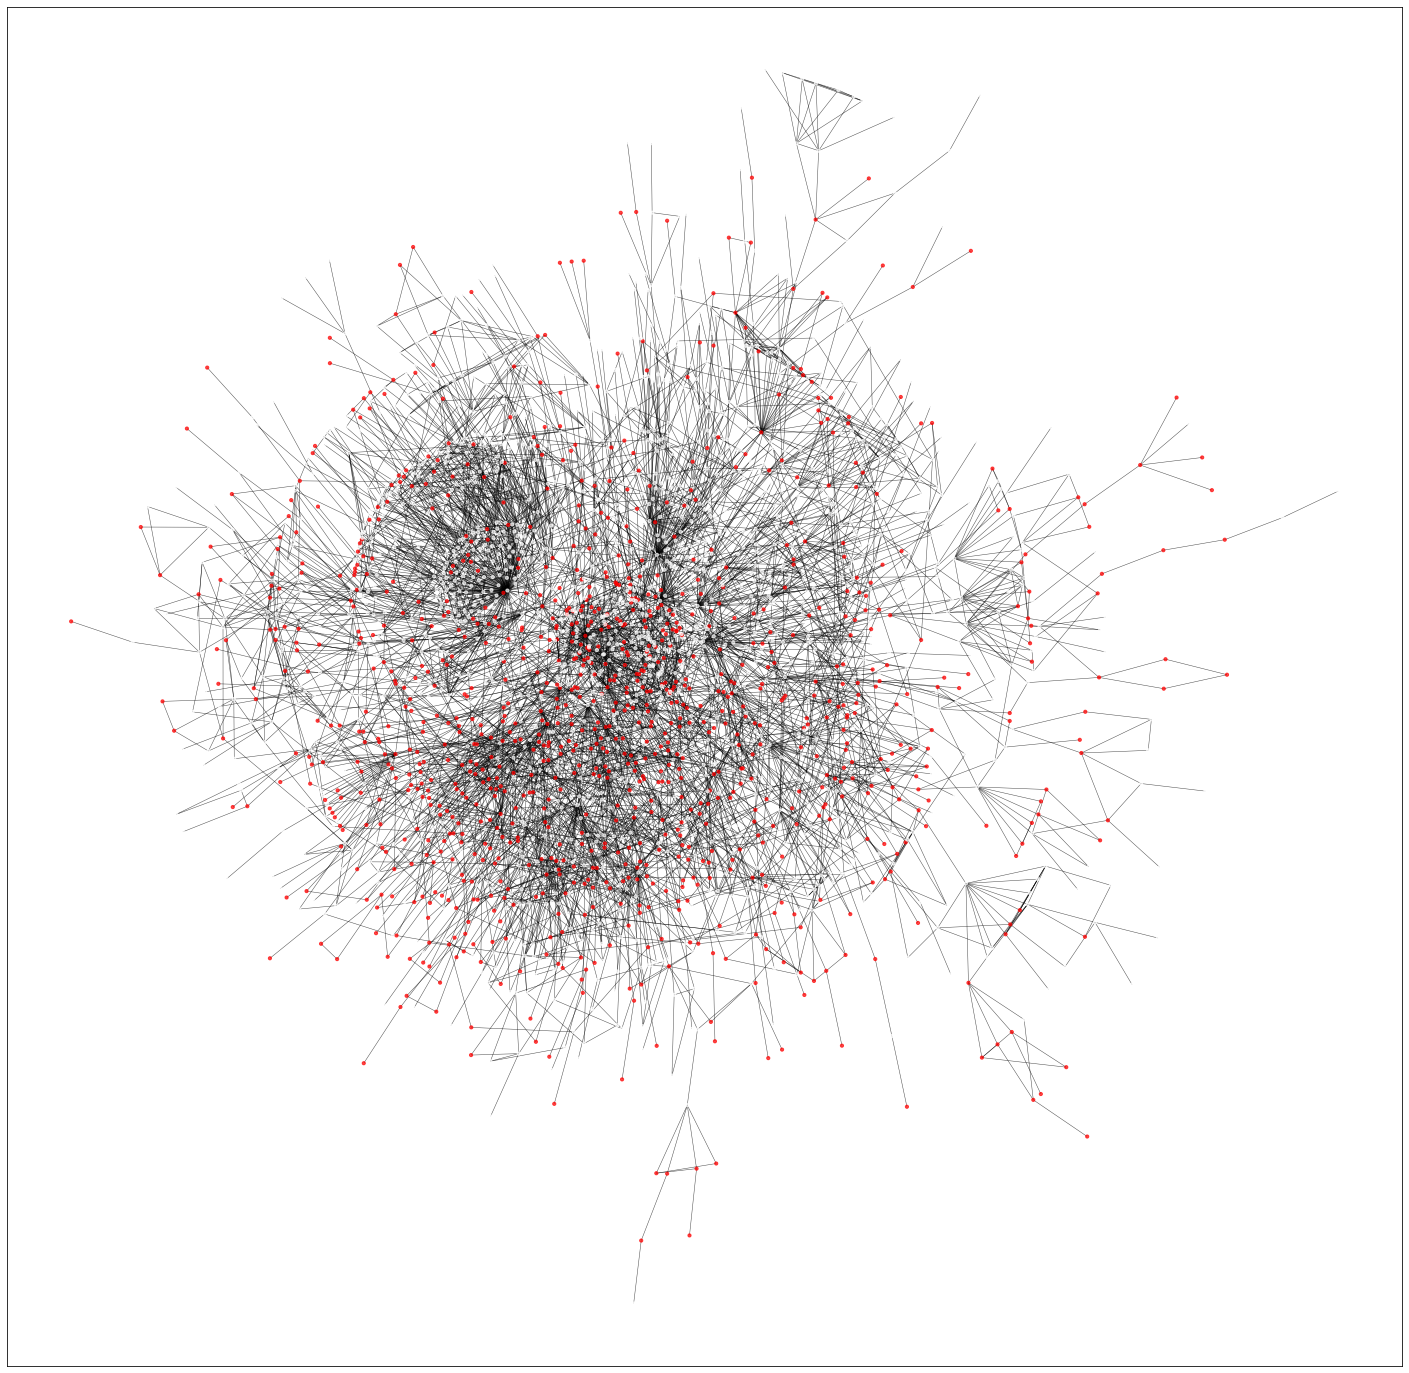

In [47]:
plt.figure(figsize=(25, 25))
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_LR_matched,
               alpha = 0.7,
               width = 0.5)
plt.show()

### Use KNeighbors Classifier on Cora dataset

In [48]:
# import dependencies
from sklearn.neighbors import KNeighborsClassifier

In [49]:
# instantiate a KNeighbour classifer class
KN = KNeighborsClassifier(n_neighbors = 7, weights = 'distance')

In [50]:
# fit on training data
KN.fit(cora_X_train, cora_y_train)
# make prediction and evaluate on training data
print('mean accuracy on training set: ', KN.score(cora_X_train, cora_y_train))

mean accuracy on training set:  1.0


In [51]:
# make prediction and evaluate on testing data
print('mean accuracy on testing set: ', KN.score(cora_X_test, cora_y_test))

mean accuracy on testing set:  0.3302180685358255


In [52]:
cora_KN_predict = KN.predict(cora_X)
# identify correct matches
cora_KN_matched = (cora_y == cora_KN_predict).astype('int32')
# color code matches
color_cora_KN_matched = pd.Series(cora_KN_matched)
color_cora_KN_matched = color_cora_KN_matched.replace(matched_color_mapping).to_numpy()

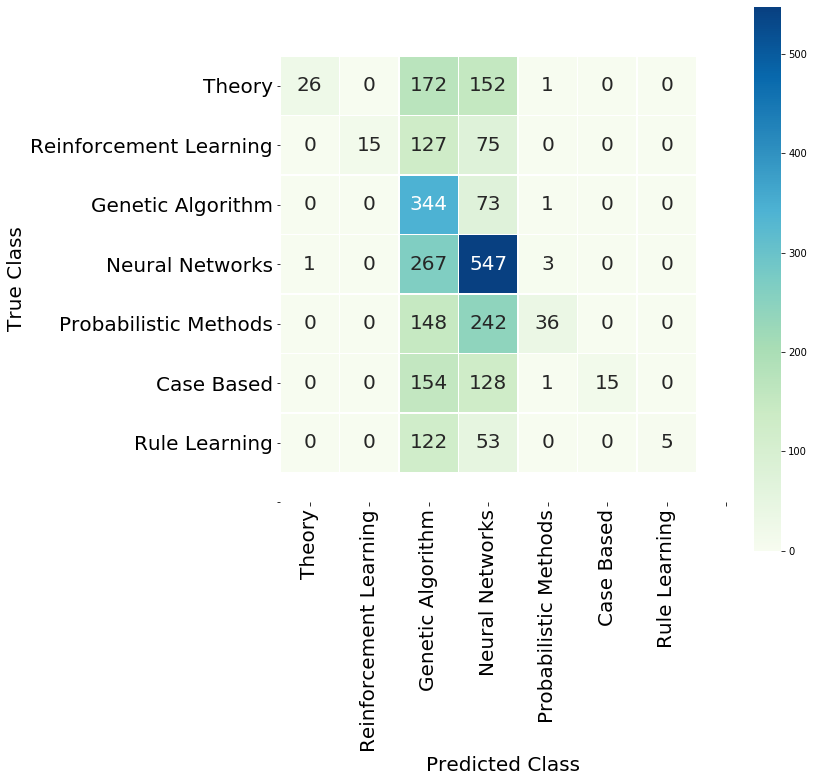

In [53]:
# create a confusion matrix 
KN_confmat = tf.math.confusion_matrix(cora_y-1, cora_KN_predict-1, num_classes=7)
# use a heatmap to visualize confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(KN_confmat.numpy(), 
            annot= True, 
            fmt = 'd',
            annot_kws = {'size': 20},
            linewidths = 0.5,
            cmap="GnBu",
            square = True)
# define ticks location and label
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 0)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
           class_labels, 
           fontsize = 20, 
           rotation = 90)
# define font size
plt.ylabel('True Class', fontdict = {'size': 20})
plt.xlabel('Predicted Class', fontdict = {'size': 20})
plt.show()

In [54]:
KN_f1 = f1_score(cora_y, cora_KN_predict, labels=[1, 2, 3, 4, 5, 6, 7], average = None)
for l, f in zip(class_labels, KN_f1):
    print('F1 score for {}: {:.2f}'.format(l, f))

F1 score for Theory: 0.14
F1 score for Reinforcement Learning: 0.13
F1 score for Genetic Algorithm: 0.39
F1 score for Neural Networks: 0.52
F1 score for Probabilistic Methods: 0.15
F1 score for Case Based: 0.10
F1 score for Rule Learning: 0.05


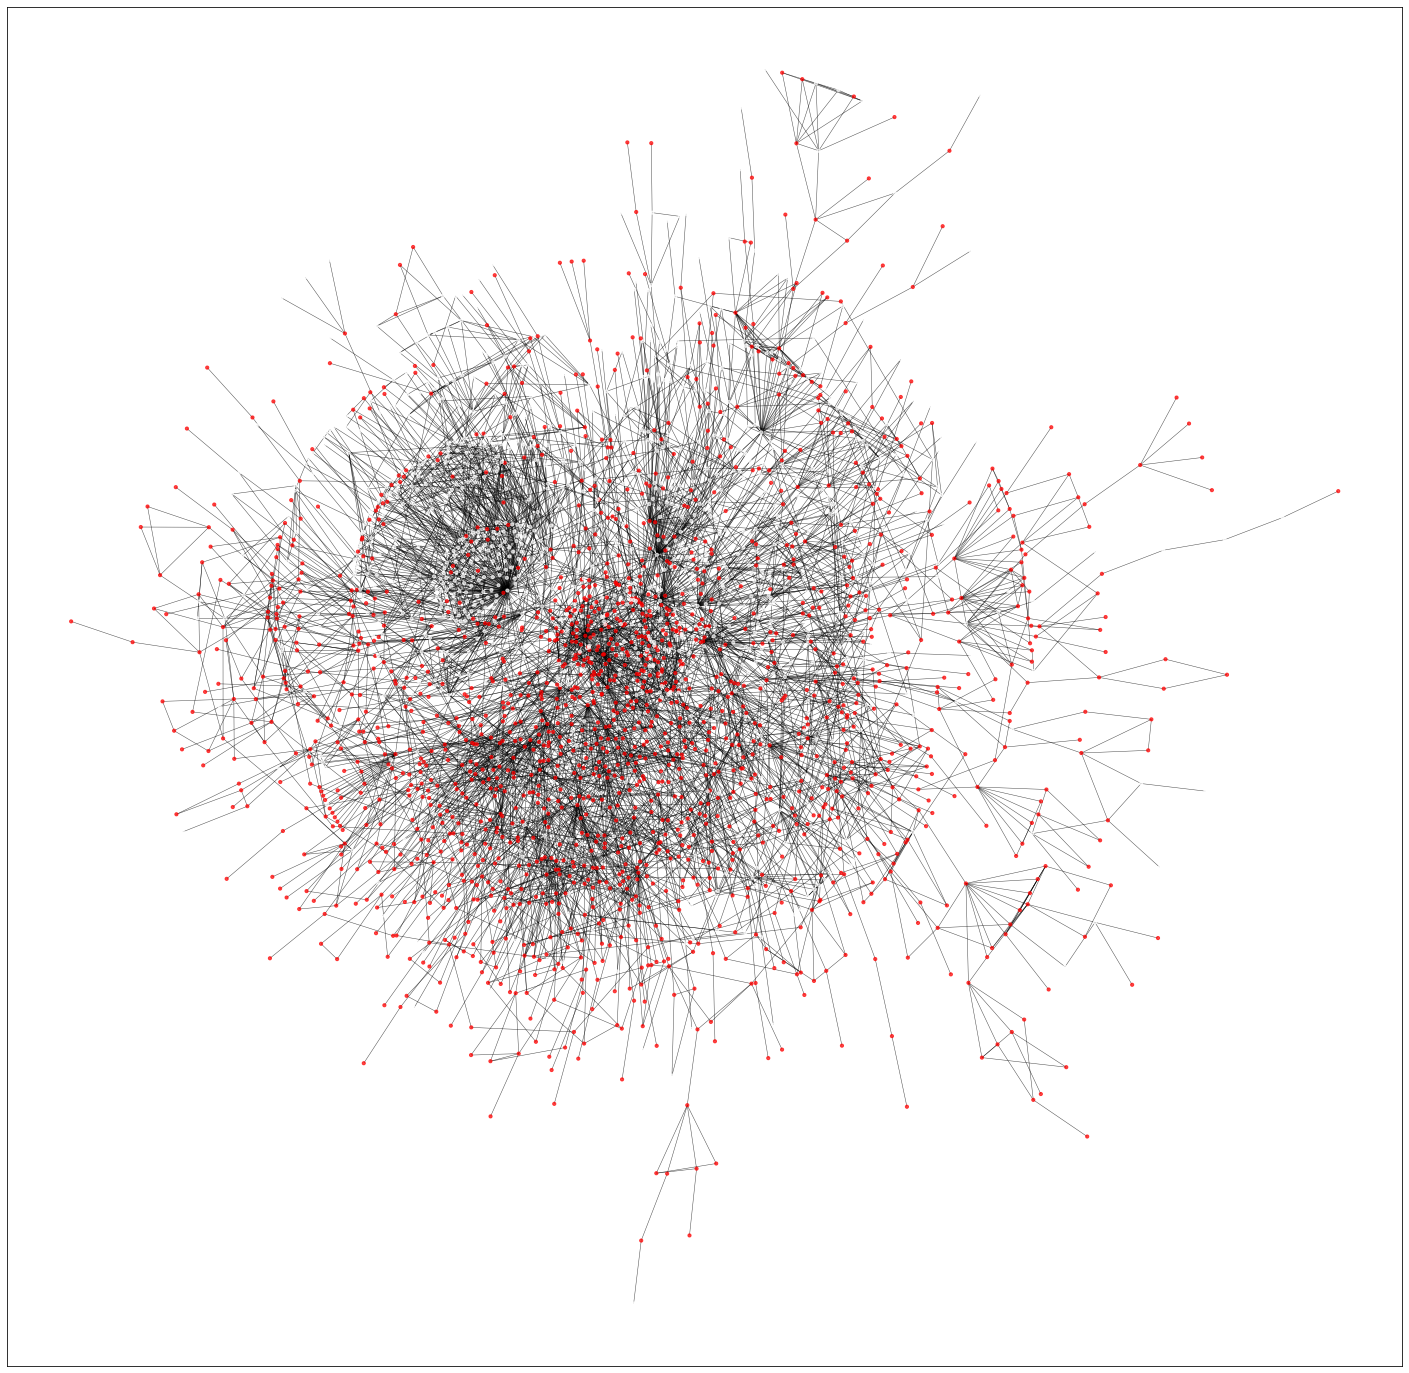

In [55]:
plt.figure(figsize=(25, 25))
# plot the graph
nx.draw_networkx(graph,
               pos = node_pos,
               with_labels = False,
               node_size = 10,
               node_color = color_cora_KN_matched,
               alpha = 0.7,
               width = 0.5)
plt.show()

### Perform GCN on the PubMed dataset ###

In [44]:
## load PubMed data set
med_A, med_X, med_L, med_train_mask, med_val_mask, med_test_mask = spektral.datasets.citation.load_data(dataset_name ='pubmed',
                                                                                                        normalize_features = True, 
                                                                                                        random_split = False)

num_med_nodes = med_A.shape[0]
num_med_features = med_X.shape[1]
num_med_classes = med_L.shape[1]

# print out attributes
print('shape of pubmed Adjacency Matrix: {} x {}'.format(num_med_nodes, num_med_nodes))
print('number of pubmed features (number of termrs): ', num_med_features)
print('number of pubmed classes: ', num_med_classes)

med_L.sum(axis = 0)

Loading pubmed dataset
Pre-processing node features
shape of pubmed Adjacency Matrix: 19717 x 19717
number of pubmed features (number of termrs):  500
number of pubmed classes:  3


array([4103, 7739, 7875])

In [45]:
med_X_in = Input(shape = (num_med_features, ))
med_A_in = Input(shape = (num_med_nodes, ), sparse = True)

med_X_1 = GraphConv(32, 'relu')([med_X_in, med_A_in])
med_X_1 = Dropout(0.5)(med_X_1)
med_X_2 = GraphConv(8, 'relu')([med_X_1, med_A_in])
med_X_2 = Dropout(0.5)(med_X_2)
med_X_3 = GraphConv(num_med_classes, 'softmax')([med_X_2, med_A_in])

med_model = Model(inputs = [med_X_in, med_A_in], outputs = med_X_3, name = 'med_GCN_model')

med_A = GraphConv.preprocess(med_A).astype('f4')
# compile model
med_model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  weighted_metrics = ['acc', tf.keras.metrics.AUC()])
med_model.summary()

Model: "med_GCN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 19717)]      0                                            
__________________________________________________________________________________________________
graph_conv_3 (GraphConv)        (None, 32)           16032       input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 32)           0           graph_conv_3[0][0]   

In [46]:
# define number of epochs
med_epochs = 50
# Prepare data
med_X = med_X.toarray()

med_val_data = ([med_X, med_A], med_L, med_val_mask)

med_model.fit([med_X, med_A], med_L,
             sample_weight = med_train_mask,
             validation_data = med_val_data,
             epochs = med_epochs,
             batch_size = num_med_nodes,
             shuffle = False,
             verbose = False)

In [47]:
# Evaluate model
med_eval_results = med_model.evaluate([med_X, med_A], 
                                      med_L,
                                      sample_weight = med_test_mask,
                                      batch_size = num_med_nodes)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*med_eval_results))

1/1 [==============================] - 0s 1ms/step - loss: 0.0551 - acc: 0.5890 - auc_1: 0.7520
Done.
Test loss: 0.055085230618715286
Test accuracy: 0.5889999866485596


### Perform GCN on the citeseer dataset ###

In [52]:
## load Citeseer data set
cs_A, cs_X, cs_L, cs_train_mask, cs_val_mask, cs_test_mask = spektral.datasets.citation.load_data(dataset_name ='citeseer',
                                                                                                        normalize_features = True, 
                                                                                                        random_split = False)

num_cs_nodes = cs_A.shape[0]
num_cs_features = cs_X.shape[1]
num_cs_classes = cs_L.shape[1]

# print out attributes
print('shape of citeseer Adjacency Matrix: {} x {}'.format(num_cs_nodes, num_cs_nodes))
print('number of citeseer features (number of termrs): ', num_cs_features)
print('number of citeseer classes: ', num_cs_classes)

cs_L.sum(axis = 0)

Loading citeseer dataset
Pre-processing node features
shape of citeseer Adjacency Matrix: 3327 x 3327
number of citeseer features (number of termrs):  3703
number of citeseer classes:  6


/usr/local/lib/python3.7/site-packages/spektral/datasets/citation.py:138: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


array([249., 590., 668., 701., 596., 508.])

In [53]:
cs_X_in = Input(shape = (num_cs_features, ))
cs_A_in = Input(shape = (num_cs_nodes, ), sparse = True)

cs_X_1 = GraphConv(64, 'relu')([cs_X_in, cs_A_in])
cs_X_1 = Dropout(0.5)(cs_X_1)
cs_X_2 = GraphConv(32, 'relu')([cs_X_1, cs_A_in])
cs_X_2 = Dropout(0.5)(cs_X_2)
cs_X_3 = GraphConv(num_cs_classes, 'softmax')([cs_X_2, cs_A_in])

cs_model = Model(inputs = [cs_X_in, cs_A_in], outputs = cs_X_3, name = 'cs_GCN_model')

cs_A = GraphConv.preprocess(cs_A).astype('f4')
# compile model
cs_model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  weighted_metrics = ['acc', tf.keras.metrics.AUC()])
cs_model.summary()

Model: "cs_GCN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 3703)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3327)]       0                                            
__________________________________________________________________________________________________
graph_conv_9 (GraphConv)        (None, 64)           237056      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 64)           0           graph_conv_9[0][0]    

In [54]:
# define number of epochs
cs_epochs = 50
# Prepare data
cs_X = cs_X.toarray()

cs_val_data = ([cs_X, cs_A], cs_L, cs_val_mask)

cs_model.fit([cs_X, cs_A], cs_L,
             sample_weight = cs_train_mask,
             validation_data = cs_val_data,
             epochs = cs_epochs,
             batch_size = num_cs_nodes,
             shuffle = False,
             verbose = False)

In [55]:
# Evaluate model
cs_eval_results = cs_model.evaluate([cs_X, cs_A], 
                                    cs_L,
                                    sample_weight = cs_test_mask,
                                    batch_size = num_cs_nodes)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*cs_eval_results))

1/1 [==============================] - 0s 1ms/step - loss: 0.5229 - acc: 0.5030 - auc_3: 0.7572
Done.
Test loss: 0.5229402780532837
Test accuracy: 0.503000020980835
